In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

page_size = 1000 # max page size

In [ ]:
maker_subgraph_url = 'https://api.thegraph.com/subgraphs/name/protofire/maker-protocol'

with open("getMakerVault.graphql", "r") as file:
    get_maker_vault_query = file.read()

data_rows = []

days = 30
for i in range(days):
    block_number = 15950000 + i * 300 * 24

    # Variables to be passed to the query
    variables = {
        "vaultId": "0x655e761c941cdbae43514f65e57865f9bc3f54ab-ETH-A",
        "blockNumber": block_number
    }
    
    r = requests.post(maker_subgraph_url, json={'query': get_maker_vault_query, 'variables': variables})
    vault_data = r.json()

    # Check if the response contains data
    if 'data' in vault_data and 'vaults' in vault_data['data'] and len(vault_data['data']['vaults']) > 0:
        # Extract the data for the DataFrame
        for row in vault_data['data']['vaults']:
            row_data = {
                'block_number': block_number,
                'debt': row['debt'],
                'collateral': row['collateral'],
                'price_value': row['collateralType']['price']['value'],
                'total_debt': row["collateralType"]["totalDebt"],
                'total_debt_normalized': row["collateralType"]["debtNormalized"],
                'total_collateral': row["collateralType"]["totalCollateral"],
            }
            data_rows.append(row_data)

df = pd.DataFrame(data_rows)

df['price_value'] = df['price_value'].astype(float)
df['collateral'] = df['collateral'].astype(float)
df['debt'] = df['debt'].astype(float)
df['total_debt'] = df['total_debt'].astype(float)
df['total_debt_normalized']= df['total_debt_normalized'].astype(float)
df['total_collateral']= df['total_collateral'].astype(float)
df["block_number"] = df["block_number"].astype(int)

df['return'] = df['price_value'].pct_change()
df['collateral_value'] = df['collateral'] * df['price_value']
df['collat_ratio'] = df['collateral_value'] / df['debt']

df.head()

In [ ]:
# Assuming df is your DataFrame with 'block_number', 'collat_ratio', and 'price_value' columns
fig = go.Figure()

# Add the first plot (collateral ratio) on the primary y-axis
fig.add_trace(go.Scatter(x=df['block_number'], y=df['collat_ratio'], mode='lines', name='Collateral Ratio'))

# Add the second plot (price value) on the secondary y-axis
fig.add_trace(go.Scatter(x=df['block_number'], y=df['price_value'], mode='lines', name='Price', yaxis='y2'))

# Create a layout with a secondary y-axis
fig.update_layout(
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right'
    ),
    xaxis=dict(title="Blocknumber")
)

# Show the figure
fig.show()

In [ ]:
plt.scatter(df['price_value'], df['collat_ratio'])
plt.xlabel('price_value')
plt.ylabel('collat_ratio')
plt.show()

In [ ]:
collateral_price_1 = 2000
debt_price_1 = 1
# collat_amount_0 = .75
collat_ratio_0=1.5
debt_amount_0 = 1000
liquidation_percentage = 0.1
max_liq_pen = .13
auction_slippage = 0.05
liquidator_incentive_pro = 0.04
liquidator_incentive_post = 0.60

# collat_ratio_0 = (collat_amount_0*collateral_price_1) / (debt_amount_0*debt_price_1)
collat_amount_0 = (collat_ratio_0*(debt_amount_0*debt_price_1))/collateral_price_1
collateral_sold = collat_amount_0*liquidation_percentage
debt_bought = (1-auction_slippage-liquidator_incentive_pro)*(collateral_sold*collateral_price_1)/(debt_price_1)
liquidator_incentive_pro_profit = liquidator_incentive_pro*(collateral_sold*collateral_price_1)/(debt_price_1)
debt_surplus = debt_bought - debt_amount_0*liquidation_percentage
liquidation_profit = min(debt_amount_0*max_liq_pen,debt_surplus)
liquidation_profit_incentive = liquidation_profit*liquidator_incentive_post
liquidation_profit_protocol = liquidation_profit- liquidation_profit*liquidator_incentive_post
collat_amount_1 = collat_amount_0 - collateral_sold
debt_amount_1 = debt_amount_0 - debt_bought 
collateral_ratio_1 = (collat_amount_1*collateral_price_1)/(debt_amount_1*debt_price_1)

print("debt_amount_0",debt_amount_0)
print("collat_amount_0",collat_amount_0)
print("collat_ratio_0",collat_ratio_0)
print("collateral_sold",collateral_sold)
print("debt_bought",debt_bought)
print("debt_surplus",debt_surplus)
print("liquidation_profit",liquidation_profit)
print("liquidation_profit_incentive",liquidation_profit_incentive)
print("liquidation_profit_protocol",liquidation_profit_protocol)
print("collat_amount_1",collat_amount_1)
print("debt_amount_1",debt_amount_1)
print("collateral_ratio_1",collateral_ratio_1)

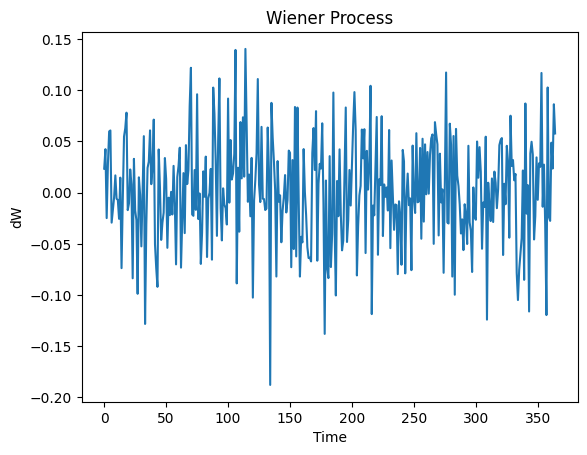

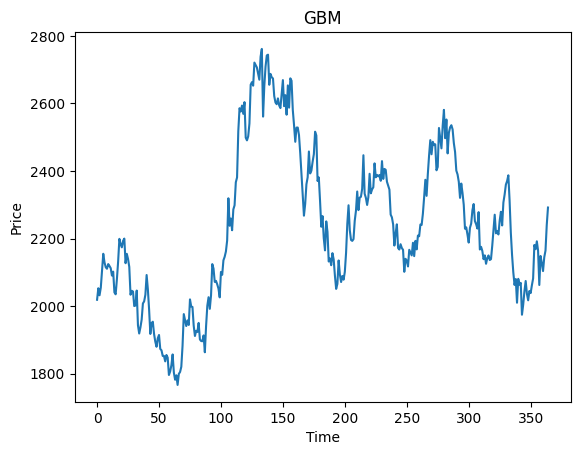

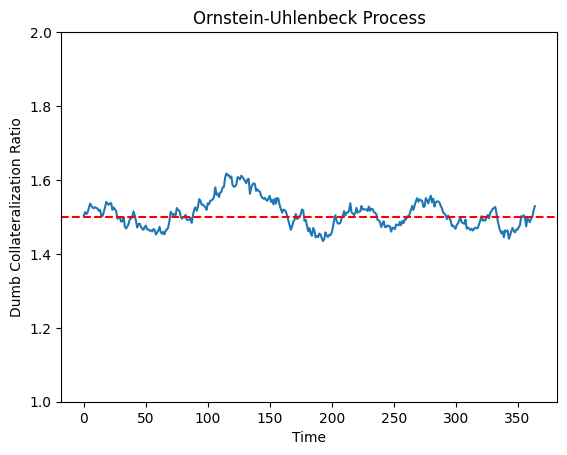

In [3]:
def gen_wiener(T = 1.0,dt = 0.01):
    N = int(T / dt)
    dW = np.random.normal(0, np.sqrt(dt), N)
    return(dW)

def gen_gbm(dW,S0 = 2000,mu = 0.0,sigma = 0.4,T = 1.0,dt = 0.01):
    N = int(T / dt)
    prices = S0*np.exp((mu - 0.5 * sigma**2) * np.arange(N) * dt + sigma * dW.cumsum())
    return(prices)

def simulate_ornstein_uhlenbeck_process(dW,mu=0,sigma=.2,theta=10,T=1,dt=0.01,base=1.6):
    N = int(T/dt)
    ou_process = base+np.exp(-theta * dt * np.arange(N)) * (mu + sigma * np.cumsum(np.exp(theta * dt * np.arange(N)) * dW))
    return(ou_process)

T = 1
dt = 1/365

dW = gen_wiener(T=T,dt=dt)

plt.plot(dW)
plt.xlabel('Time')
plt.ylabel('dW')
plt.title('Wiener Process')
plt.show()

gbm = gen_gbm(dW,T=T,dt=dt)

plt.plot(gbm)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('GBM')
plt.show()

collat_ratio = simulate_ornstein_uhlenbeck_process(dW,T=T,dt=dt)

plt.plot(collat_ratio)
plt.xlabel('Time')
plt.ylabel('Dumb Collateralization Ratio')
plt.title('Ornstein-Uhlenbeck Process')

liquidation_threshold = 1.5

plt.ylim(ymin=1.5-.5, ymax=1.5+.5)
plt.axhline(y=liquidation_threshold, color='r', linestyle='--')
plt.show()


/var/folders/0c/f8mzvlf17x9brkzz58g4tpn80000gn/T/ipykernel_1347/2473351341.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index,'liquidatable'] = False


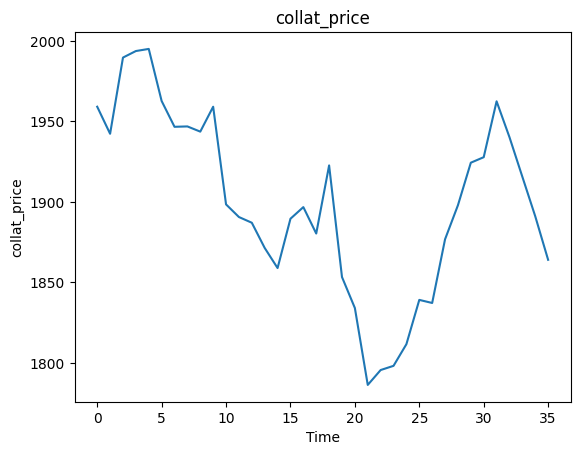

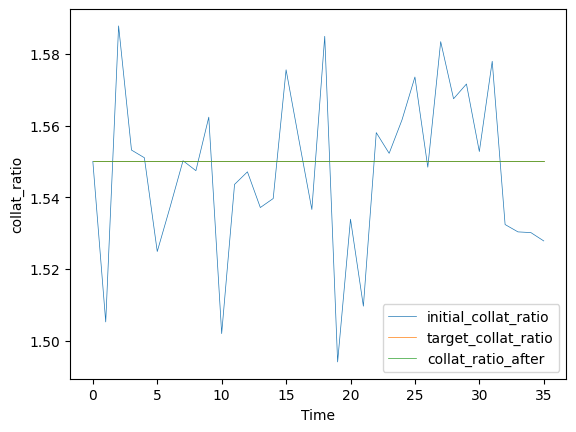

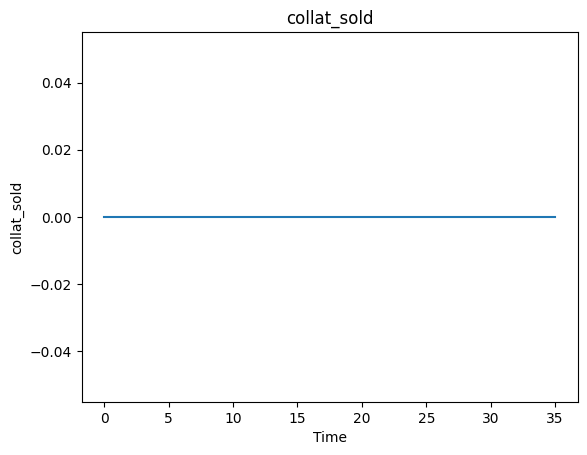

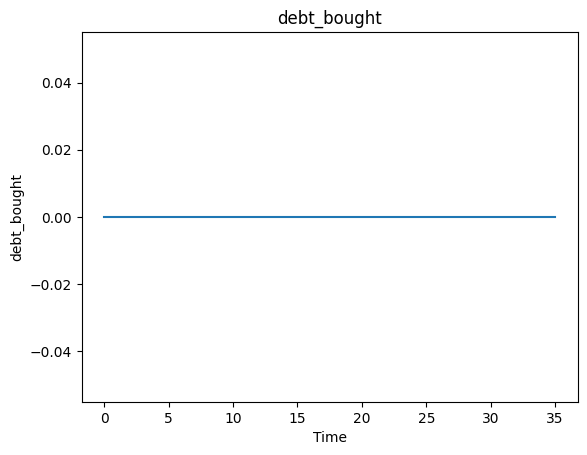

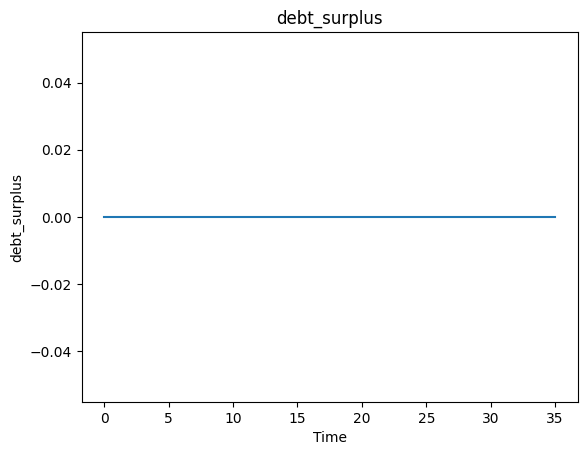

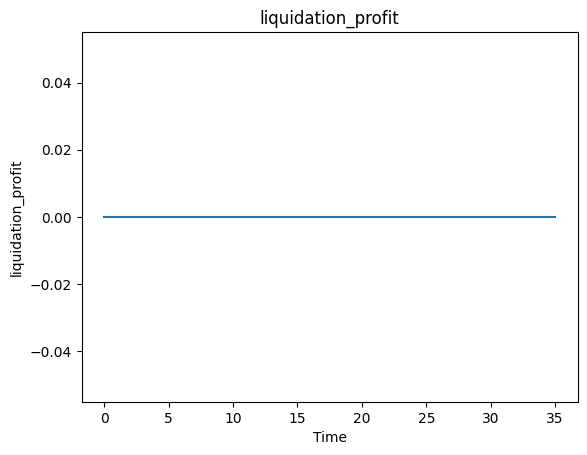

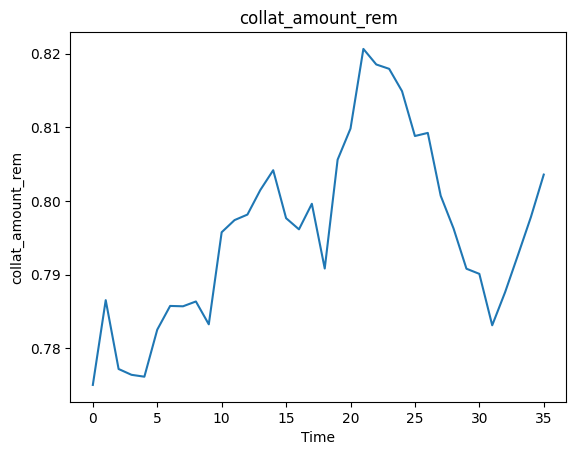

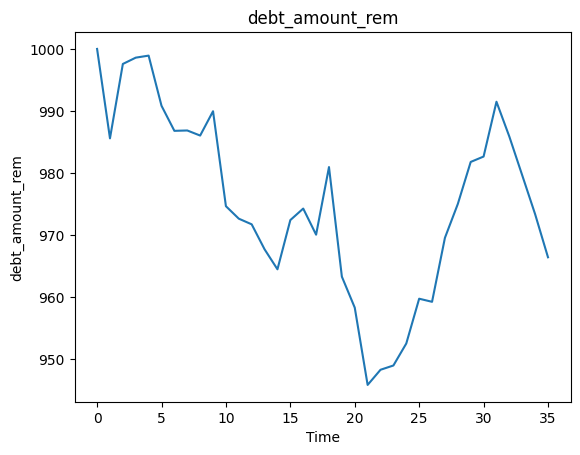

,dW,debt_price,collat_price,initial_collat_ratio,target_collat_ratio,collat_amount,debt_amount,liquidatable,collat_sold,debt_bought,debt_surplus,liquidator_incentive_pro_profit,liquidation_profit,liquidation_profit_incentive,liquidation_profit_protocol,collat_amount_rem,debt_amount_rem,collat_ratio_after
0,-0.051674,1,1959.084757,1.550000,1.55,0.775000,1000.000000,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.775000,1000.000000,1.55
1,-0.020974,1,1942.291872,1.505276,1.55,0.786513,985.572968,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786513,985.572968,1.55
2,0.060702,1,1989.593309,1.587748,1.55,0.777164,997.574001,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777164,997.574001,1.55
3,0.005640,1,1993.649814,1.553160,1.55,0.776373,998.590958,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.776373,998.590958,1.55
4,0.002197,1,1994.965658,1.551023,1.55,0.776117,998.920502,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.776117,998.920502,1.55
5,-0.040280,1,1962.650047,1.524892,1.55,0.782507,990.829955,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782507,990.829955,1.55
6,-0.019959,1,1946.616512,1.537338,1.55,0.785729,986.782747,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785729,986.782747,1.55
7,0.000849,1,1946.851063,1.550187,1.55,0.785682,986.842197,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785682,986.842197,1.55
8,-0.003612,1,1943.614213,1.547423,1.55,0.786336,986.021831,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786336,986.021831,1.55
9,0.020363,1,1959.080850,1.562334,1.55,0.783232,989.945048,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.783232,989.945048,1.55


In [11]:
def gen_wiener(T = 1.0,dt = 0.01):
    N = int(T / dt)
    dW = np.random.normal(0, np.sqrt(dt), N)
    return(dW)

def gen_gbm(dW,S0 = 2000,mu = 0.0,sigma = 0.4,T = 1.0,dt = 0.01):
    N = int(T / dt)
    prices = S0*np.exp((mu - 0.5 * sigma**2) * np.arange(N) * dt + sigma * dW.cumsum())
    return(prices)

def simulate_ornstein_uhlenbeck_process(dW,mu=0,sigma=.2,theta=10,T=1,dt=0.01,base=1.5):
    N = int(T/dt)
    ou_process = base+np.exp(-theta * dt * np.arange(N)) * (mu + sigma * np.cumsum(np.exp(theta * dt * np.arange(N)) * dW))
    return(ou_process)

def next_target_cr(prev_cr,dW, mu=0, sigma=0.2, theta=10, dt=0.01, base=1.5):
    # # Adjust mean reversion term to revert towards 'base' instead of 'mu'
    # mean_reversion_term = theta * (base - prev_ou) * dt

    # # Calculate the next value in the Ornstein-Uhlenbeck process
    # next_ou = prev_ou + mean_reversion_term + sigma * dW
    # return min(next_ou,base)
    
    return max(base, prev_cr + theta * (mu - prev_cr) * dt + sigma * dW)

    # return(1.5)
    
def df_plot(df,var):
    plt.plot(df[var])
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.title(var)
    plt.show()

def df_plot_mult(df,vars,ytitle):
    for var in vars:
        plt.plot(df[var], label=var, linewidth=.5)
    plt.xlabel('Time')
    plt.ylabel(ytitle)
    plt.legend()
    plt.show()

T = .1
dt = 1/365
collateral_price_1 = 2000
debt_size = 1000
liquidation_percentage = 0.1
max_liq_pen = .13
auction_slippage = 0.05
liquidator_incentive_pro = 0.04
liquidator_incentive_post = 0.60
target_cr = 1.55
liquidation_threshold = 1.5
ratio_add_collat_v_debt = 0.5
management_strength = .9

df = pd.DataFrame()
df["dW"] = gen_wiener(T=T,dt=dt)
df["debt_price"] = 1
df["collat_price"] = gen_gbm(df["dW"],S0=collateral_price_1,T=T,dt=dt)

for index, row in df.iterrows():
    if index==0:        
        df.at[index, 'initial_collat_ratio'] = target_cr
        df.at[index, 'target_collat_ratio'] = target_cr
        df.at[index, "collat_amount"] = (target_cr*(debt_size*row['debt_price']))/collateral_price_1
        df.at[index, "debt_amount"] = debt_size
        df.at[index,'liquidatable'] = False
    else:
        df.at[index, 'initial_collat_ratio'] = (df.at[index-1,"collat_amount_rem"]*df.at[index,"collat_price"])/(df.at[index-1,"debt_amount_rem"]*df.at[index,"debt_price"])
        df.at[index, 'target_collat_ratio'] = next_target_cr(df.at[index-1, 'collat_ratio_after'],row["dW"],mu=0, sigma=0.2, theta=10, dt=dt, base=target_cr)    
        
        # df.at[index, "collat_amount"] = df.at[index-1, "collat_amount_rem"]
        # df.at[index, "debt_amount"] = df.at[index-1, "debt_amount_rem"]
        df.at[index, "collat_amount"] = df.at[index-1, "collat_amount_rem"] + management_strength*(ratio_add_collat_v_debt * ((df.at[index-1, "debt_amount_rem"]*df.at[index, 'target_collat_ratio'] / df.at[index, "collat_price"]) - df.at[index-1, "collat_amount_rem"]))
        df.at[index, "debt_amount"] = df.at[index-1, "debt_amount_rem"] + management_strength*((1-ratio_add_collat_v_debt) * (((df.at[index-1, "collat_amount_rem"]*df.at[index, 'collat_price']) / df.at[index, "target_collat_ratio"]) - df.at[index-1, "debt_amount_rem"]))

        df.at[index,'liquidatable'] = df.at[index-1,'collat_ratio_after']<liquidation_threshold


    if df.at[index,'liquidatable']:
        df.at[index, "collat_sold"] = df.at[index,"collat_amount"]*liquidation_percentage
        df.at[index, "debt_bought"] = (1 - auction_slippage - liquidator_incentive_pro) * (df.at[index, "collat_sold"] * df.at[index, "collat_price"]) / df.at[index, "debt_price"]
        df.at[index, "debt_surplus"] = df.at[index, "debt_bought"] - df.at[index, "debt_amount"] * liquidation_percentage
        df.at[index, "liquidator_incentive_pro_profit"] = liquidator_incentive_pro * (df.at[index, "collat_sold"] * df.at[index, "collat_price"]) / df.at[index, "debt_price"]
    else:
        df.at[index, "collat_sold"] = 0
        df.at[index, "debt_bought"] = 0
        df.at[index, "debt_surplus"] = 0
        df.at[index, "liquidator_incentive_pro_profit"]=0        
    
    df.at[index, "liquidation_profit"] = max(0, max_liq_pen * df.at[index, "debt_surplus"])
    df.at[index, "liquidation_profit_incentive"] = df.at[index, "liquidation_profit"] * liquidator_incentive_post
    df.at[index, "liquidation_profit_protocol"] = df.at[index, "liquidation_profit"] * (1 - liquidator_incentive_post)
    
    df.at[index, "collat_amount_rem"] = df.at[index, "collat_amount"] - df.at[index, "collat_sold"]
    df.at[index, "debt_amount_rem"] = df.at[index, "debt_amount"] - df.at[index, "debt_bought"]
    
    if index == 0:
        df.at[index,'collat_ratio_after'] = target_cr
    else:
        df.at[index, 'collat_ratio_after'] = (df.at[index,"collat_amount_rem"]*df.at[index,"collat_price"])/(df.at[index,"debt_amount_rem"]*df.at[index,"debt_price"])

df_plot(df,"collat_price")
df_plot_mult(df,["initial_collat_ratio","target_collat_ratio","collat_ratio_after"],"collat_ratio")
df_plot(df,"collat_sold")
df_plot(df,"debt_bought")
df_plot(df,"debt_surplus")
df_plot(df,"liquidation_profit")
df_plot(df,"collat_amount_rem")
df_plot(df,"debt_amount_rem")


df.head(100)

In [ ]:
import random
from linear_regression import linear_regression
b_0, b_1 = linear_regression(df['price_value'], df['collat_ratio'])

# print("b_0: ", b_0)
# print("b_1: ", b_1)

# # plot the scatterplot and the regression line
# plt.scatter(df['price_value'], df['collat_ratio'])
# plt.xlabel('price_value')
# plt.ylabel('collat_ratio')
# plt.plot(df['price_value'], b_0 + b_1 * df['price_value'], color='red')
# plt.show()

liquidation_ratio = 1.63
liquidation_penalty = 0.13

def liquidationCheck(collateral, debt, collat_ratio, clearing_price):
    if collat_ratio < liquidation_ratio:
        return (True, collateral * clearing_price * (1 - liquidation_penalty) - debt)
    else:
        return (False, 0)



def monte_carlo_var(df, num_simulations, holding_period, alpha, starting_price):
    mean_return = df['return'].mean()
    std_return =df['return'].std()

    liquidation_events = 0
    losses = 0
    simulated_end_price = []
    for _ in range(num_simulations):
        curr_returns = 1 
        for _ in range(holding_period):
            curr_returns *= 1 + random.gauss(mean_return, std_return) 
            curr_price = starting_price * curr_returns
            h_f = b_0 + b_1 * curr_price

            (got_liquidated, loss) = liquidationCheck(
                df['collateral'].tail(1).item(), df['debt'].tail(1).item(), h_f, curr_price
            )
            if got_liquidated:
                
                losses += loss
                liquidation_events += 1
                break


    liquidation_probability = liquidation_events / num_simulations
    print("Expected loss: ", losses / num_simulations)
    return liquidation_probability


# params
num_simulations = 10000
holding_period = 1
alpha = 0.01

# run monte carlo simulation
monte_carlo_var = monte_carlo_var(
    df, num_simulations, holding_period, alpha, 1650
)
print("Liquidation probability: ", monte_carlo_var)